# Length of Stay Model   
With xgboost()

Running this notebook will create the length of stay models uisng xgboost() . The models will be saved in a folder *myxgboostLOSmodelsfolder* in your current working directory.

## Outline <a id="BackToTop"></a>

  * [Problem Description](#probdesc)
  * [Get Data](#getdata)
  * [Data Description](#datadesc)
  * [Data Exploration](#dataexp)
  * [Feature Engineering](#featureeng)
  * [Prepare Training and Test Datasets](#trdata)
  * [Create the Model](#model)
  * [Results](#results)

## Problem Description  <a id="probdesc"></a>
### Why predict the Length of Stay?

The recent legislative changes have standardized payments for procedures performed, regardless of the number of days the patient actually spends in the hospital. The hospitals are hard pressed to use resources more efficiently and find ways to accommodate more patients with the same volume of resources. An accurate prediction of length of stay can help the hospitals in numerous ways.  
1) Manage bed occupancy.   
2) Effective scheduling of elective admissions   
3) Improve patient satisfaction during hospital stay.   

Extended lengths of stay costs hospitals millions of dollars a year. By identifying patients at risk for an extended stay, they can take proactive measures to formulate a treatment plan to reduce the length of stay.

### When should the prediction be used?  

We want to predict the length of stay at the time of admission using the information available at the time of admission. The columns that contain discharge information or other information not likely to be available at the time of admission are not used for building the model. The model could be consumed by the admitting nurse or staff. The data contains encounter level records for a million or so patients from 23 hospitals. We want to predict the length of stay of patients based on historic data.

 [Back To Top](#BackToTop)

## Get Data  <a id="getdata"></a>

In [ ]:
# clear workspace
rm(list=ls())
gc()

In [ ]:
Sys.time()
url1 = "https://phm.blob.core.windows.net/models/core_data.csv"
url2 = "https://phm.blob.core.windows.net/models/charges_data.csv"
url3 = "https://phm.blob.core.windows.net/models/severity_data.csv"
url4 = "https://phm.blob.core.windows.net/models/dxpr_data.csv"

pathd = getwd()
dest1 = paste(pathd,"/core_data.csv",sep='')
dest2 = paste(pathd,"/charges_data.csv",sep='')
dest3 = paste(pathd,"/severity_data.csv",sep='')
dest4 = paste(pathd,"/dxpr_data.csv",sep='')

download.file(url1,dest1)
download.file(url2,dest2)
download.file(url3,dest3)
download.file(url4,dest4)
Sys.time()

#### Takes about a minute or so to download all the files depending on the bandwidth

In [ ]:
Sys.time()
dat_core = read.csv(dest1)
dat_chrg = read.csv(dest2)
dat_sevr = read.csv(dest3)
dat_dxpr = read.csv(dest4)
Sys.time()


#### Takes couple of minutes to read all the files

In [52]:
dim(dat_core)
dim(dat_chrg)
dim(dat_sevr)
dim(dat_dxpr)

[1] 1103172     248

[1] 1103172     155

[1] 1103172      30

[1] 1103172     180

In [4]:
dat = merge(merge(merge(dat_sevr, dat_chrg, by = "KEY"), dat_core, by = "KEY"), dat_dxpr, by ="KEY")  #the columns are in same order as streaming data
dim(dat)

[1] 1103172     610

 [Back To Top](#BackToTop)

## Data Description  <a id="datadesc"></a>

#### To learn more about what these columns mean please visit  the data dictionary url
https://www.hcup-us.ahrq.gov/db/state/siddist/siddistvarnote2013.jsp


In [ ]:
names(dat)

Sanity check on the integrity of downloaded data to make sure that the month column contains the values for months and so on.

In [ ]:
unique(dat$AYEAR) 
unique(dat$AMONTH) 
length(unique(dat$AMONTH))
unique(dat$FEMALE)

We will use the following 135 columns for building a model for length of stay. 

In [7]:
cols_demographic = c('AGE','FEMALE','RACE','MEDINCSTQ','PSTATE','ZIP','HOSPST','PAY1','PAY2','PAY3') 
cols_admitinfo = c('KEY','VisitLink','DSHOSPID','ATYPE','AMONTH','PointOfOriginUB04','TRAN_IN')
cols_Diagnosis_present_on_admission = grep('DXPOA',names(dat),value=T)
cols_ECode_present_on_admission = grep('E_POA',names(dat),value=T)
cols_ICD9_CM_Chronic_Condition_Indicators = grep('^CHRON[0-9]',names(dat),value=T)
cols_Chronic_Condition_Indicators_BodySystem = grep('^CHRONB',names(dat),value=T)
cols_comorbidity_measure_ICD9_CMcodes = grep('^CM_',names(dat),value=T)
cols_primaryDiagnosis = c('DX1','DXCCS1','DXMCCS1')
cols_counts = c('NDX','NCHRONIC')
cols_Target = c('LOS')
cols4los = c(cols_demographic, cols_admitinfo, cols_Diagnosis_present_on_admission, cols_ECode_present_on_admission, 
             cols_ICD9_CM_Chronic_Condition_Indicators, cols_Chronic_Condition_Indicators_BodySystem, cols_comorbidity_measure_ICD9_CMcodes, 
             cols_primaryDiagnosis, cols_counts, cols_Target)
length(cols4los)

[1] 135

In [8]:
dat4los = dat[,cols4los]
dim(dat4los)

[1] 1103172     135

 [Back To Top](#BackToTop)

## Data Exploration

In [42]:
cat_cols = c('DSHOSPID','FEMALE','RACE','ATYPE','AMONTH','PointOfOriginUB04','TRAN_IN','MEDINCSTQ','PSTATE','PAY1','DXCCS1','DXMCCS1','ZIP3')

apply(dat4los[,cat_cols],2,FUN=function(x){length(unique(x))})
apply(dat4los[,cat_cols],2,FUN=function(x){unique(x)})

DSHOSPID            FEMALE              RACE             ATYPE 
               23                 2                 7                 5 
           AMONTH PointOfOriginUB04           TRAN_IN         MEDINCSTQ 
               12                12                 3                 4 
           PSTATE              PAY1            DXCCS1           DXMCCS1 
               25                 6               263                19 
             ZIP3 
               27

$DSHOSPID
 [1] "hosp_17" "hosp_13" "hosp_11" "hosp_22" "hosp_9"  "hosp_1"  "hosp_14"
 [8] "hosp_23" "hosp_6"  "hosp_16" "hosp_2"  "hosp_5"  "hosp_12" "hosp_18"
[15] "hosp_4"  "hosp_15" "hosp_3"  "hosp_19" "hosp_8"  "hosp_21" "hosp_10"
[22] "hosp_20" "hosp_7" 

$FEMALE
[1] "Female" "Male"  

$RACE
[1] "1"  "-9" "2"  "5"  "4"  "3"  "6" 

$ATYPE
[1] "ATYPE_2" "ATYPE_1" "ATYPE_3" "ATYPE_4" "ATYPE_5"

$AMONTH
 [1] "8"  "3"  "9"  "5"  "4"  "6"  "12" "2"  "1"  "10" "7"  "11"

$PointOfOriginUB04
 [1] "4" "1" "6" "8" "5" "2" "7" "B" "E" "C" "D" "F"

$TRAN_IN
[1] "1" "0" "2"

$MEDINCSTQ
[1] "1" "3" "2" "4"

$PSTATE
 [1] "GA" "CO" "IN" "WA" "IL" "NY" "MS" "SD" "VT" "MA" "RI" "MI" "WV" "CT" "NJ"
[16] "MO" "HI" "NE" "MD" "AZ" "AK" "NM" "MT" "AR" "VA"

$PAY1
[1] "2" "3" "6" "1" "4" "5"

$DXCCS1
  [1] "183" "142" "45"  "181" "218" "661" "47"  "203" "193" "157" "155" "189"
 [13] "234" "657" "170" "61"  NA    "195" "217" "191" "237" "112" "244" "185"
 [25] "146" "182" "87"  "204" "205" "141" "125" "106" "233" "55"  "63"  "5"  
 [37] "144" "145" "196" "186" "231" "95"  "238" "187" "93"  "98"  "211" "184"
 [49] "99"  "169" "201" "7"   "246" "118" "207" "58"  "159" "78"  "14"  "120"
 [61] "122" "2"   "110" "42"  "229" "151" "19"  "50"  "103" "59"  "160" "83" 
 [73] "108" "153" "152" "127" "12"  "143" "224" "660" "115" "96"  "653" "242"
 [85] "192" "130" "97"  "241" "230" "102" "109" "114" "190" "29"  "226" "216"
 [97] "27"  "17"  "128" "240" "147" "209" "107" "228" "235" "81"  "116" "172"
[109] "236" "248" "126" "149" "101" "208" "24"  "250" "212" "39"  "165" "131"
[121] "16"  "197" "28"  "259" "129" "199" "222" "21"  "138" "168" "60"  "51" 
[133] "232" "43"  "140" "35"  "659" "90"  "20"  "136" "210" "254" "6"   "253"
[145] "85"  "251" "100" "225" "161" "171" "139" "33"  "79"  "32"  "117" "188"
[157] "148" "133" "227" "221" "105" "123" "257" "4"   "132" "219" "11"  "113"
[169] "164" "162" "15"  "670" "135" "111" "252" "215" "38"  "163" "213" "84" 
[181] "44"  "76"  "137" "651" "46"  "18"  "202" "154" "25"  "166" "175" "124"
[193] "9"   "36"  "8"   "239" "245" "62"  "41"  "652" "104" "49"  "214" "134"
[205] "256" "121" "92"  "243" "56"  "220" "650" "91"  "48"  "34"  "156" "198"
[217] "13"  "180" "1"   "88"  "54"  "80"  "158" "194" "52"  "167" "3"   "26" 
[229] "247" "40"  "94"  "23"  "177" "173" "77"  "64"  "37"  "31"  "223" "200"
[241] "89"  "255" "57"  "655" "30"  "249" "178" "22"  "82"  "662" "179" "656"
[253] "258" "654" "119" "658" "663" "10"  "206" "53"  "176" "86"  "174"

$DXMCCS1
 [1] "11" "9"  "2"  "15" "5"  "13" "10" "16" "4"  NA   "14" "7"  "6"  "8"  "3" 
[16] "1"  "17" "12" "18"

$ZIP3
 [1] "333" "349" "322" "334" "336" "338" "330" "335" "325" "329" "324" "321"
[13] "320" "346" "331" "342" "323" "341" "337" "328" "347" "332" "339" "327"
[25] "326" "344" NA

Distribution of Length Of Stay

0.7
1.9
3.1
4.3
5.5
6.7


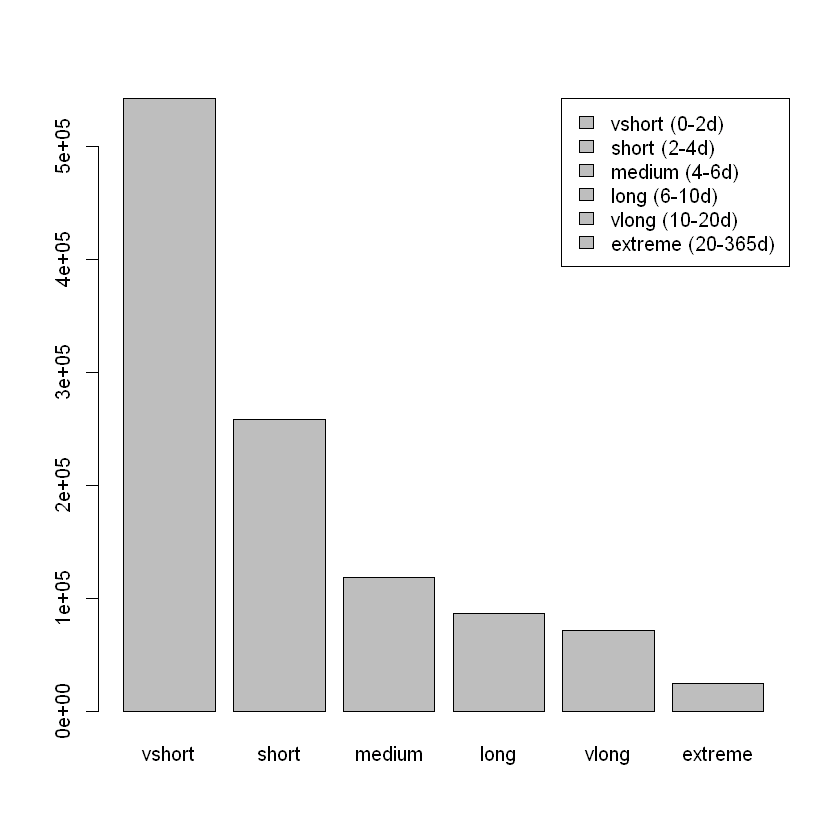

In [48]:
losbreaks = c(0,2,4,6,10,20,365)
loslabels = c('vshort','short','medium','long','vlong','extreme')

losdist = data.frame(table(cut(as.numeric(dat4los$LOS),breaks=losbreaks, labels=loslabels )))

bp = barplot(losdist$Freq, names.arg = losdist$Var1)
bp
legend("topright",  fill=c("grey"), c('vshort (0-2d)','short (2-4d)','medium (4-6d)','long (6-10d)','vlong (10-20d)','extreme (20-365d)')  ) #c(0,2,4,6,10,20,365)

 [Back To Top](#BackToTop)

## Feature Engineering  <a id="featureeng"></a>
Create some additional features from raw data

In [9]:
#------------------------
#DXPOA1 - DXPOA25  
indDXPOA = grep('DXPOA',names(dat4los))
#convert all  'Y' to 1 for DXPOA columns
dat4los[,indDXPOA]=apply(dat4los[,indDXPOA],2,FUN=function(x){ifelse(x=='Y',1,x)}) 
#now convert rest to 0 for DXPOA columns
dat4los[,indDXPOA]=apply(dat4los[,indDXPOA],2,FUN=function(x){ifelse(x==1,x,0)})

#create a column num_DXPOA
#for these 25 columns , loop over all rows..for each row give me count of number of 1s ..(valid values will be 0 to 25)
dat4los$num_DXPOA = apply(dat4los[,indDXPOA],1,FUN=function(x){length(x[x=='1'])})

dat4los = dat4los[,-indDXPOA]  #delete all DXPOA cols

#-------------------------------
#E_POA1 to E_POA8  
#convert all non 'Y' to 0 for E_PAO
indE_POA = grep('E_POA',names(dat4los))
dat4los[,indE_POA]=apply(dat4los[,indE_POA],2,FUN=function(x){ifelse(x=='Y',1,x)}) #NO Y in simulated data
dat4los[,indE_POA]=apply(dat4los[,indE_POA],2,FUN=function(x){ifelse(x==1,x,0)})

#create a column num_E_POA
dat4los$num_E_POA = apply(dat4los[,indE_POA],1,FUN=function(x){length(x[x=='1'])})

dat4los = dat4los[,-indE_POA]  #delete all E_POA cols

#-------------------------------------
#CHRON1 - CHRON25  
indCHRON = grep('^CHRON[0-9]',names(dat4los))
#create a column num_CHRON..SAME AS NCHRONIC in the data actually
#dat4los$num_CHRON = apply(dat4los[,cols4],1,FUN=function(x){length(x[x==1])})

dat4los = dat4los[,-indCHRON]  #delete all CHRON cols..only keeping their count

#------------------------------------------
#CHRONB1 - CHRONB25  
indchronB = grep('^CHRONB[0-9]',names(dat4los))

#create a column num_uCHRONB get number of unique CHRONB
dat4los$num_uCHRONB =  apply(dat4los[indchronB],1,FUN=function(x){length(unique(x[!is.na(x)]))})

dat4los = dat4los[,-indchronB]  # deleting all CHRONB cols..only keeping their count

#--------------------------------------
#PAY2 and PAY3 have a lot of -9 so removing these cols and creating num_PAY
indPAY = grep('PAY',names(dat4los),value=T)
dat4los$num_PAY = apply(dat4los[,grep('PAY',names(dat4los),value=T)],1,FUN=function(x){length(x[!is.na(x)])})

#remove PAY2 and PAY3 now
dat4los$PAY2 = NULL
dat4los$PAY3 = NULL

#---------------------------------------
#CM_AIDS,.. 
indCM = grep('CM_',names(dat4los))
dat4los$num_CM = apply(dat4los[,indCM],1,FUN=function(x){(length(x[x==1]))})

dat4los = dat4los[,-indCM]  # deleting all CM cols

#----------------------------
# Clean column PointOfOriginUB04 (HCUP data has a " " character in this column)

indgood = grep('[0-9A-Za-z]',dat4los$PointOfOriginUB04)
dat4los = dat4los[indgood,] #removing rows with invalid values

#----------------------------
#remove HOSPST as there is only one value 'FL' in simulated data
dat4los = dat4los[,!names(dat4los) %in% c('HOSPST')]

#----------------------------
#removing DX1. Will use a higher level diagnosis info in DXCCS1 instead
dat4los = dat4los[,!names(dat4los) %in% c('DX1')]

#----------------------------
# Will use only the first 3 digits of Zip code
dat4los$ZIP3 = substr(dat4los$ZIP,1,3)
dat4los$ZIP  = NULL


In [10]:
dim(dat4los)

[1] 1103172      24

We will use these 24 columns for modelling. 

In [19]:
# make these columns categorical
cat_cols = c('DSHOSPID','FEMALE','RACE','ATYPE','AMONTH','PointOfOriginUB04','TRAN_IN','MEDINCSTQ','PSTATE','PAY1','DXCCS1','DXMCCS1','ZIP3')

makecatg = sapply(dat4los[,cat_cols],FUN=function(x){as.factor(x)})
makecatg = as.data.frame(makecatg)
dat4los[,cat_cols] = makecatg

# make these columns numeric
cat_num  = c('AGE', 'LOS', 'NDX', 'NCHRONIC', 'num_DXPOA', 'num_E_POA', 'num_uCHRONB', 'num_PAY', 'num_CM')

makenum  = sapply(dat4los[,cat_num],FUN=function(x){as.numeric(x)})
makenum  = as.data.frame(makenum)
dat4los[,cat_num] = makenum

data_mod = dat4los
str(data_mod)

'data.frame':	1103172 obs. of  24 variables:
 $ AGE              : num  32 24 49 32 0 90 61 0 60 21 ...
 $ FEMALE           : Factor w/ 2 levels "Female","Male": 1 2 1 1 1 1 1 2 2 1 ...
 $ RACE             : Factor w/ 7 levels "-9","1","2","3",..: 2 1 2 3 2 2 2 6 2 2 ...
 $ MEDINCSTQ        : Factor w/ 4 levels "1","2","3","4": 1 1 3 3 1 2 4 1 3 2 ...
 $ PSTATE           : Factor w/ 25 levels "AK","AR","AZ",..: 6 4 6 9 24 8 19 14 8 21 ...
 $ PAY1             : Factor w/ 6 levels "1","2","3","4",..: 2 3 6 2 2 1 3 2 2 2 ...
 $ KEY              : int  1 2 3 4 5 6 7 8 9 10 ...
 $ VisitLink        : Factor w/ 1000000 levels "ID.1","ID.10",..: 896051 348974 990082 300356 681789 669669 833392 732245 840761 523770 ...
 $ DSHOSPID         : Factor w/ 23 levels "hosp_1","hosp_10",..: 9 5 3 15 23 1 1 6 16 20 ...
 $ ATYPE            : Factor w/ 5 levels "ATYPE_1","ATYPE_2",..: 2 1 3 2 4 3 3 4 3 1 ...
 $ AMONTH           : Factor w/ 12 levels "1","10","11",..: 11 6 12 8 7 9 9 11 7 4 ...
 $ PointOfO

In [49]:
levelinfo = sapply(dat4los[,cat_cols],FUN=function(x){unique(x)})

In [51]:
str(levelinfo)
levelinfo[['FEMALE']]
levelinfo[['RACE']]
save(levelinfo,'listoflevels.Rdata')
cat('saved in',getwd())

List of 13
 $ DSHOSPID         : Factor w/ 23 levels "hosp_1","hosp_10",..: 9 5 3 15 23 1 6 16 20 8 ...
 $ FEMALE           : Factor w/ 2 levels "Female","Male": 1 2
 $ RACE             : Factor w/ 7 levels "-9","1","2","3",..: 2 1 3 6 5 4 7
 $ ATYPE            : Factor w/ 5 levels "ATYPE_1","ATYPE_2",..: 2 1 3 4 5
 $ AMONTH           : Factor w/ 12 levels "1","10","11",..: 11 6 12 8 7 9 4 5 1 2 ...
 $ PointOfOriginUB04: Factor w/ 12 levels "1","2","4","5",..: 3 1 5 7 4 2 6 8 11 9 ...
 $ TRAN_IN          : Factor w/ 3 levels "0","1","2": 2 1 3
 $ MEDINCSTQ        : Factor w/ 4 levels "1","2","3","4": 1 3 2 4
 $ PSTATE           : Factor w/ 25 levels "AK","AR","AZ",..: 6 4 9 24 8 19 14 21 23 10 ...
 $ PAY1             : Factor w/ 6 levels "1","2","3","4",..: 2 3 6 1 4 5
 $ DXCCS1           : Factor w/ 262 levels "1","10","100",..: 93 49 199 91 132 232 201 116 104 64 ...
 $ DXMCCS1          : Factor w/ 18 levels "1","10","11",..: 3 18 11 7 14 5 2 8 13 NA ...
 $ ZIP3             : Factor 

[1] Female Male  
Levels: Female Male

[1] 1  -9 2  5  4  3  6 
Levels: -9 1 2 3 4 5 6

saved in C:/dsvm/notebooks/HealthcareSolution

#### Function to compute Regression results

In [21]:
# Function to compute Regression results 

regression_res <- function(Target,Prediction){
  res = data.frame(Target=Target, Scored.Labels=Prediction)
  res$delta = abs(res$Target - res$Scored.Labels)
  res$percdelta = res$delta/res$Target
  
  n = nrow(res)  #dim(res)[1]
  #MAE = Mean Absolute Error
  MAE = sum(res$delta)/n  
  MAE
  
  #RMSE = Root Mean Squared Error
  RMSE = sqrt(sum(res$delta ^ 2)/n)
  RMSE
  #correlation coefficient
  cor(res$Target,res$Scored.Labels)
  
  #coefficient of determination
  Rsquare = (cor(res$Target,res$Scored.Labels) ^ 2)*100
  Rsquare
  
  
  #Relative Absolute Error
  RAE = sum(res$delta)/sum(abs(mean(res$Target) - res$Target))
  RAE
  #Relative Squared Error
  RSE = sum(res$delta ^ 2)/sum(abs(mean(res$Target) - res$Target) ^ 2)
  RSE
  
  
  results = data.frame(MAE=MAE, RMSE=RMSE, RAE=RAE, RSE=RSE, Rsq = Rsquare)
  
  return(results)
}


 [Back To Top](#BackToTop)

## Prepare Training and Test Datasets  <a id="trdata"></a>

The training data should be representative of all cases. While preparing the training and test data, we will ensure that model is trained on data that contains all the levels. The training and  test data should also have unique patients.


 [Back To Top](#BackToTop)

## Create the Model <a id="model"></a>
We will create 10 models for 10 individual hospitals and an additional model for all the other hospitals.

In [22]:
# select a few hospitals to build individual models for

# paste(sort(unique(data_mod$DSHOSPID)), collapse="','")
selected_hosp = c('hosp_1','hosp_2','hosp_3','hosp_4','hosp_5','hosp_6','hosp_7','hosp_8','hosp_9','hosp_10')
allotherhosp  = unique(data_mod$DSHOSPID)[!unique(data_mod$DSHOSPID) %in% selected_hosp]
allotherhosp  = as.character(allotherhosp)  #"hosp_17" "hosp_13" "hosp_11" "hosp_22" "hosp_14" "hosp_23" "hosp_16" "hosp_12" "hosp_18" "hosp_15" "hosp_19" "hosp_21" "hosp_20"
allotherhosp

[1] "hosp_17" "hosp_13" "hosp_11" "hosp_22" "hosp_14" "hosp_23" "hosp_16"
 [8] "hosp_12" "hosp_18" "hosp_15" "hosp_19" "hosp_21" "hosp_20"

In [37]:
# create a data frame for storing training and testing metrics
res_train = data.frame(model_name='hosp_X_LOSmodel', MAE=0, RMSE=0, RAE=0, RSE=0, Rsq=0)
res_train = res_train[-1,]
res_test = data.frame(model_name='hosp_X_LOSmodel', MAE=0, RMSE=0, RAE=0, RSE=0, Rsq=0)
res_test = res_test[-1,]


We will use xgboost to build a regression model.

Create a folder in current working directiry ro save the models.

In [ ]:
wrdir = getwd()
modeldir = 'myxgboostLOSmodelsfolder'
dir.create(file.path(wrdir, modeldir), showWarnings = FALSE)
modelsLocation = paste(wrdir,modeldir,sep='/')
modelsLocation = paste0(modelsLocation,'/')
modelsLocation


In [ ]:
if(!require(xgboost){
    install.packages("xgboost")
    library(xgboost)
}
if(!require(caret){
    install.packages("caret")
    library(caret)
}

In [38]:
for (h in 1:(length(selected_hosp)+1)){
  # subset data for the hospital to build a model for
  cat('h=',h,'\n')
  if(h==(length(selected_hosp)+1)){
    cat('allotherhosp',allotherhosp,'\n')
    sub_data_mod = subset(data_mod,data_mod$DSHOSPID %in% allotherhosp)
    cat(unique(as.character(sub_data_mod$DSHOSPID)),'\n')
    model_name = paste('allotherhosp','_LOSmodel',sep='')
    model_name = paste0(modelsLocation, model_name)
    cat('model_name =',model_name,'\n')
  } else {
    cat('selected_hosp[h]',selected_hosp[h],'\n')
    sub_data_mod = subset(data_mod,data_mod$DSHOSPID %in% selected_hosp[h])
    cat(unique(as.character(sub_data_mod$DSHOSPID)),'\n')
    model_name = paste(unique(as.character(sub_data_mod$DSHOSPID)),'_LOSmodel',sep='')
    model_name = paste0(modelsLocation, model_name)
    cat('model_name =',model_name,'\n')
  }
  
  dim(sub_data_mod)
  # sub_data_mod contains data for a hospital, build LOS model for this hospital and save the model with name model_name
    
  sub_data_mod = sub_data_mod[complete.cases(sub_data_mod),] # ensure all rows are complete
    
  # convert categorical variable into numeric vector using One Hot Encoding
  # --- one-hot-encoding categorical features
  ohe_feats = cat_cols
  oheformula <- as.formula(paste('~',paste(cat_cols,collapse=' + '),sep=' '))

  dummies = dummyVars(oheformula, data = sub_data_mod)
  df_all_ohe = as.data.frame(predict(dummies, newdata = sub_data_mod)) # takes time
  
  df_all_combined = cbind(sub_data_mod[,-c(which(colnames(sub_data_mod) %in% ohe_feats))],df_all_ohe)  
  
  # split df_all_combined into train and test
  # 60% of the sample size for training
  smp_size = floor(0.6 * nrow(df_all_combined))
  
  set.seed(18) ## set the seed 
  split.index = sample(seq_len(nrow(df_all_combined)), size = smp_size,replace=F)
  
  
  train_xgb = df_all_combined[split.index, ]
  test_xgb  = df_all_combined[-split.index, ]
  
  nrow(data_mod); nrow(train_xgb); nrow(test_xgb) ;nrow(train_xgb)+ nrow(test_xgb)
  #now have the data split into training and testing ~60% training and 40% testing
  
  #==================================================================
  #ensuring unique patients in train and test
  #==================================================================
  # check how many patients overlap
  # table(unique(test_xgb$VisitLink) %in% unique(train_xgb$VisitLink))
  # table(unique(train_xgb$VisitLink) %in% unique(test_xgb$VisitLink))
  
  # patient ids that occur in both train and test  
  vk  = unique(test_xgb$VisitLink)[unique(test_xgb$VisitLink) %in% unique(train_xgb$VisitLink)]
  vk1 = vk[1:round(length(vk)/2)]
  vk2 = vk[(round(length(vk)/2)+1) : length(vk)]
  
  
  torm4mtest_xgb = which(test_xgb$VisitLink %in% vk1)     # patient ids to remove from test
  
  train_xgb = rbind(train_xgb,test_xgb[torm4mtest_xgb,])  # append rows with these patients to train
  test_xgb = test_xgb[-torm4mtest_xgb,]    # remove these patient rows from test
  
  # nrow(data_mod); nrow(train_xgb); nrow(test_xgb) ;nrow(train_xgb)+ nrow(test_xgb)
  # 100*nrow(train_xgb)/nrow(data_mod); 100*nrow(test_xgb)/nrow(data_mod)
  
  torm4mtrain_xgb = which(train_xgb$VisitLink %in% vk2)   # patient ids to remove from train
  
  test_xgb  = rbind(test_xgb,train_xgb[torm4mtrain_xgb,]) # append rows with these patients to test
  train_xgb = train_xgb[-torm4mtrain_xgb,]  # remove these patient rows from train
  
  # confirm unique patients in training and test data
  # table(unique(test_xgb$VisitLink) %in% unique(train_xgb$VisitLink))
  # table(unique(train_xgb$VisitLink) %in% unique(test_xgb$VisitLink))
  
  #-----------------------------------------
  # remove unnecessary cols
  train_xgb$myrownum = NULL
  test_xgb$myrownum = NULL
  
  train_xgb$KEY = NULL
  test_xgb$KEY = NULL
  
  train_xgb$VisitLink = NULL
  test_xgb$VisitLink = NULL
  
  train_xgb$DSHOSPID = NULL
  test_xgb$DSHOSPID = NULL
  
  # now have the data split into training and testing ~60% training and ~40% testing
  #---------------------------------------------
  
  labels_xgb = train_xgb$LOS
  
  #remove LOS column from training data
  grep('LOS',names(train_xgb))
  train_xgb_2  = train_xgb[-grep('LOS',names(train_xgb))]
  
  #----------------------------------------------------------------
  #Tune and Run the model
  rm(xgb_LOSmod)
  set.seed(18)
  xgb_LOSmod <- xgboost(data = data.matrix(train_xgb_2), label = labels_xgb, 
                        booster = "gbtree",   
                        eta = 0.1, 
                        gamma = 0, 
                        max_depth = 3, 
                        nround=25, 
                        subsample = 0.5,  
                        colsample_bytree = 0.5, 
                        eval_metric = "rmse", 
                        objective = "reg:linear"
  )
  
  # save model to binary local file
  xgb.save(xgb_LOSmod, model_name)  # should return TRUE
  
  # Object "xgb_LOSmod"  is an xgboost model.
  # To load binary model to R we would - xgb.load(model_name) 
  
   
  # check how the model does on test data - save in res_test
  y_pred = predict(xgb_LOSmod, data.matrix(test_xgb))
  Target = test_xgb$LOS
  
  res_test_xgboost = regression_res(Target,y_pred)
  tst = data.frame(model_name=as.character(as.data.frame(strsplit(model_name,split = '/myxgboostLOSmodelsfolder/'))[2,1]))
  tst = cbind(tst,res_test_xgboost)
  res_test = rbind(res_test, tst)
  
  # model results - training data - save in res_train
  y_predTr <- predict(xgb_LOSmod, data.matrix(train_xgb))
  TargetTr = train_xgb$LOS
  
  res_train_xgboost = regression_res(TargetTr,y_predTr)
  trn = data.frame(model_name=as.character(as.data.frame(strsplit(model_name,split = '/myxgboostLOSmodelsfolder/'))[2,1]))
  trn = cbind(trn,res_train_xgboost)
  res_train = rbind(res_train, trn)
  
}



h= 1 
selected_hosp[h] hosp_1 
hosp_1 
model_name = C:/dsvm/notebooks/HealthcareSolution/myxgboostLOSmodelsfolder/hosp_1_LOSmodel 
[0]	train-rmse:6.316763
[1]	train-rmse:5.881966
[2]	train-rmse:5.515919
[3]	train-rmse:5.176391
[4]	train-rmse:4.896605
[5]	train-rmse:4.631811
[6]	train-rmse:4.399269
[7]	train-rmse:4.210396
[8]	train-rmse:4.043420
[9]	train-rmse:3.895852
[10]	train-rmse:3.763003
[11]	train-rmse:3.647740
[12]	train-rmse:3.547632
[13]	train-rmse:3.467206
[14]	train-rmse:3.396231
[15]	train-rmse:3.334638
[16]	train-rmse:3.263630
[17]	train-rmse:3.215100
[18]	train-rmse:3.162505
[19]	train-rmse:3.124672
[20]	train-rmse:3.088894
[21]	train-rmse:3.053427
[22]	train-rmse:3.022339
[23]	train-rmse:2.998860
[24]	train-rmse:2.973335
h= 2 
selected_hosp[h] hosp_2 
hosp_2 
model_name = C:/dsvm/notebooks/HealthcareSolution/myxgboostLOSmodelsfolder/hosp_2_LOSmodel 
[0]	train-rmse:6.910805
[1]	train-rmse:6.445659
[2]	train-rmse:6.019333
[3]	train-rmse:5.663050
[4]	train-rmse:5.353824
[5]

 [Back To Top](#BackToTop)

## Model Performance <a id="results"></a>

In [39]:
cat('Trained Model \n')
res_train
cat('Performance on Test data \n')
res_test

Trained Model 


,model_name,MAE,RMSE,RAE,RSE,Rsq
1,hosp_1_LOSmodel,9.205078,11.77763,2.978346,4.216309,43.86685
2,hosp_2_LOSmodel,10.02924,12.02828,2.776495,3.72683,60.90206
3,hosp_3_LOSmodel,14.79372,17.0838,3.849871,5.166368,51.7405
4,hosp_4_LOSmodel,9.402094,11.48448,2.445988,2.608544,60.40359
5,hosp_5_LOSmodel,10.13871,11.90958,3.004405,4.030877,71.24828
6,hosp_6_LOSmodel,9.41778,10.94949,3.151026,4.261185,48.11338
7,hosp_7_LOSmodel,9.292182,10.86904,3.06485,3.978368,60.02023
8,hosp_8_LOSmodel,10.21984,11.92614,3.350918,4.744185,64.33339
9,hosp_9_LOSmodel,10.61745,12.50012,3.209466,4.801981,45.76147
10,hosp_10_LOSmodel,11.7624,15.24325,3.061035,5.140573,59.6694


Performance on Test data 


,model_name,MAE,RMSE,RAE,RSE,Rsq
1,hosp_1_LOSmodel,9.19608,11.7951,2.927956,4.146828,43.21412
2,hosp_2_LOSmodel,10.00705,11.93932,2.85496,4.065886,63.92422
3,hosp_3_LOSmodel,14.78745,17.09465,3.799057,5.005565,49.94271
4,hosp_4_LOSmodel,9.452949,11.47449,2.501006,3.00421,63.36318
5,hosp_5_LOSmodel,10.20592,12.00105,3.040975,4.461805,73.54233
6,hosp_6_LOSmodel,9.469541,11.05122,3.149421,4.249647,47.49567
7,hosp_7_LOSmodel,9.322999,10.94363,3.08918,3.97753,58.47231
8,hosp_8_LOSmodel,10.11097,11.7828,3.2261,4.353985,63.53583
9,hosp_9_LOSmodel,10.5807,12.49544,3.271246,4.807506,43.37753
10,hosp_10_LOSmodel,11.78402,15.22843,3.086348,5.477073,62.71113
